# Homework 5

In this notebook, you will explore kernel ridge regression and kernel SVM. We first present kernel ridge regression on a housing dataset to showcase the ideas in Question 3 on the theoretical portion of the homework. Next, we start our exploration into kernel SVM with a two-dimensional example on the spiral data and then build a simple but powerful sentiment classifier on tweets to airlines, a topic we may have more sympathy for as inclement weather hits us here in Chicago...

## Preparation

In [25]:
# !gdown 1aZdzUafp91XYlv1xaVj7qpBXfVx8_Pvc

In [2]:
import os
import numpy as np
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn import svm
import matplotlib.pyplot as plt
import utils
import pickle 

## Kernel Ridge Regression

In the Question 3 of the theoretical homework, we studied kernel ridge regression. In this part, we will address the practical considerations for solving the kernel ridge regression problem.

We consider the [California housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset), which consists of 8 numeric features, including house age, number of bedrooms, and location, and has target median house value. It contains over 20 thousand samples. We will use 3000 for now, but feel free to use more to see what happens! First, let us load it from `sklearn`'s set of datasets.

In [68]:
cal  = sklearn.datasets.fetch_california_housing()

In [69]:
from utils import TrainAndTestData

seed = 0
np.random.seed(seed)

m = 3000
perm = np.random.permutation(len(cal.target))
train_i = perm[:m]
test_i = perm[m:]
train_X = cal.data[train_i,:]
train_y = cal.target[train_i]
test_X = cal.data[test_i,:]
test_y = cal.target[test_i]

housing_data = TrainAndTestData(train_X, train_y, test_X, test_y)

Let use a Gaussian (RBF) kernel. Recall that the definition of this kernel is:

$$
    K_{RBF}(x_i, x_j) = \exp \left( -\beta \left(  \langle x_i, x_i \rangle + \langle x_j, x_j \rangle - 2\langle x_i, x_j \rangle  \right)    \right)
$$

In [70]:
def RBF_kernel(beta = 1):
    def RBF_kernel_beta(x1,x2):
        return np.exp(- beta*(np.sum(x1*x1, 1)[:,np.newaxis] + np.sum(x2*x2, 1)-2*x1@x2.T ))
    return RBF_kernel_beta

*A quick note on closure: the above kernel construction function employs a Python concept known as `closure` which provides us the following functionality. Every kernel function should have the same signature: given two data points as input, output a real number. However, the function may be dependent on some parameter that we cannot hard code. Thus, the outer function constructs a kernel function with the desired signature while fixing a value for the parameter. This becomes very useful when we may need to pass around a kernel function but always for the same parameter value*

To use this function, we first pick some value of `beta` and instantiate: `RBF_kernel(beta=myvalue)`. This is itself a function and can now take in matrices `x1, x2`. That is:

In [71]:
RBF_kernel(beta = 1)(housing_data.X_train[:10], housing_data.X_train[:10])

array([[1.00000000e+000, 0.00000000e+000, 1.24418120e-052,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [1.24418120e-052, 0.00000000e+000, 9.99999999e-001,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        5.13597624e-152],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.0

### [Task 1] Looking for a great $\beta$ value
Look at the values of the kernel with $\beta=1$. What pattern do you observe about the values? Generally, what is the largest value that a Gaussian kernel can achieve? What is the smallest value that a Gaussian kernel can achieve? How does the kernel with $\beta=1$ compare to the upper bound and the lower bound? You should notice this is not a good choice of $\beta$. How can you improve this? Find a good setting for $\beta$ by considering these questions.

In [73]:
#### TASK 1 CODE
beta=10**(-6)
betas = np.logspace(-7, -5, 10)
best_beta = 0
best_min = np.inf
for beta in betas:
    ker_data = RBF_kernel(beta = beta)(housing_data.X_train, housing_data.X_train)
    if np.min(ker_data[ker_data != 0]) < best_min:
        best_beta = beta
        best_min = np.min(ker_data[ker_data != 0])
ker_data = RBF_kernel(beta = best_beta)(housing_data.X_train, housing_data.X_train)
print(f"The max value attained in this kernel is {np.max(ker_data)} and the min value is {np.min(ker_data[ker_data != 0])}. The best beta is {best_beta}")
print(ker_data)
#### TASK 1 CODE

The max value attained in this kernel is 1.0000000000000535 and the min value is 5e-324. The best beta is 3.5938136638046257e-06
[[1.         0.79130504 0.99957057 ... 0.58989626 0.3135914  0.53029647]
 [0.79130504 1.         0.7871057  ... 0.94222565 0.70245401 0.90668556]
 [0.99957057 0.7871057  1.         ... 0.5858934  0.30955633 0.52558313]
 ...
 [0.58989626 0.94222565 0.5858934  ... 1.         0.87866743 0.9931472 ]
 [0.3135914  0.70245401 0.30955633 ... 0.87866743 1.         0.92342485]
 [0.53029647 0.90668556 0.52558313 ... 0.9931472  0.92342485 1.        ]]


In [74]:
beta = best_beta
print(f'Using beta = {beta}')

Using beta = 3.5938136638046257e-06


Armed with a good kernel to represent our features well, we move on to the learning algorithm.

### [Task 2] Implementing Kernel Ridge Regression
Now, let us implement the kernel ridge regression solution `train_kernel_ridge`. In 2(b), you formulated the solution to the kernel ridge regression as computing the least squares solution to some expression. `predict_kernel_ridge` will compute the prediction given the kernel, the validation points $x$, the predictor $\alpha$, and the training points. Finish the functions below using proper numeric python syntax.

In [ ]:
def train_kernel_ridge(kernel, lmbd, x, y):
    from numpy.linalg import lstsq
    K = kernel(x,x)
    #### TASK 2 CODE
    m = x.shape[0]
    A = (K +  lmbd * np.eye(m))
    least_squares_soln = lstsq(A, y)[0]
    #### TASK 2 CODE
    return least_squares_soln

In [76]:
def predict_kernel_ridge(kernel, x, alpha, train_x):
    #### TASK 2 CODE
    return kernel(x, train_x) @ alpha
    #### TASK 2 CODE

In [77]:
kernel = RBF_kernel(beta = beta)
lmbd = 0.1
alpha = train_kernel_ridge(kernel, lmbd, housing_data.X_train, housing_data.y_train)
train_preds = predict_kernel_ridge(kernel, housing_data.X_train, alpha, housing_data.X_train)

Given this, load and process the data into the Gram matrix, compute the KRR solution for this data for some fixed regularization parameter $\lambda$, and predict the answers on a validation set.

**Check yourself**: How long does the `train_kernel_ridge` function take to run? Are you inverting a matrix?

Great. You now are able to compute the KRR solution for data. Let's compute some baselines to know what we're trying to beat. Implement the following two (extremely simple) predictors. We will compute the mean squared error of them later.
* **null predictor**: output 0 for every data point
* **mean predictor**: output the mean of the training `y` for every data point

In [78]:
def mean_squared_error(pred, y):
    return np.mean((pred-y)**2)

In [79]:
#### TASK 2 CODE
## BASELINES
def null_predictor(x):
    return np.zeros(x.shape[0])

def mean_predictor(train_y, x):
    return np.mean(train_y) * np.ones(len(x))

#### TASK 2 CODE

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 1]</h4>

For the code block below, use cross-validation or validation to choose $\lambda$. Make sure you beat the baselines. What values of $\beta, \lambda$ give good performance? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: The best values of lambda and beta were found to be lambda=0.001 and beta = 2.9836472402833405e-06. The MSE is 0.5793619624415502
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

In [159]:
"""
Contents of task2_worker.py

import os
import numpy as np
import sklearn.datasets
from sklearn.model_selection import KFold
import utils
import pickle 
from utils import TrainAndTestData
import concurrent.futures

def train_val_split(data, train, predict, loss, kernel, train_index, val_index, lmbd = 1, beta = 0.2):
    ker = kernel(beta = beta)
    train_X, val_X = data.X_train[train_index], data.X_train[val_index]
    train_y, val_y = data.y_train[train_index], data.y_train[val_index]
    alpha = train(ker, lmbd, train_X, train_y)
    preds = predict(ker, val_X, alpha, train_X)
    return loss(preds, val_y)

def RBF_kernel(beta = 1):
    def RBF_kernel_beta(x1,x2):
        return np.exp(- beta*(np.sum(x1*x1, 1)[:,np.newaxis] + np.sum(x2*x2, 1)-2*x1@x2.T ))
    return RBF_kernel_beta

def train_kernel_ridge(kernel, lmbd, x, y):
    from numpy.linalg import lstsq
    K = kernel(x,x)
    #### TASK 2 CODE
    m = x.shape[0]
    A = (K +  lmbd * np.eye(m))
    least_squares_soln = lstsq(A, y)[0]
    #### TASK 2 CODE
    return least_squares_soln
def predict_kernel_ridge(kernel, x, alpha, train_x):
    #### TASK 2 CODE
    return kernel(x, train_x) @ alpha
    #### TASK 2 CODE
def mean_squared_error(pred, y):
    return np.mean((pred-y)**2)

if __name__ == '__main__':
    # init data
    cal = sklearn.datasets.fetch_california_housing()
    seed = 0
    np.random.seed(seed)
    m = 3000
    perm = np.random.permutation(len(cal.target))
    train_i = perm[:m]
    test_i = perm[m:]
    train_X = cal.data[train_i,:]
    train_y = cal.target[train_i]
    test_X = cal.data[test_i,:]
    test_y = cal.target[test_i]
    housing_data = TrainAndTestData(train_X, train_y, test_X, test_y)
    # init param space
    betas = 3.5938136638046257e-06 + np.logspace(-6.5, -5.5, 3)
    lmbds = np.logspace(-4,-2, 9)
    folds = 5
    mses = np.zeros((len(betas), len(lmbds)))

    # parallelize and cv
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = {
            executor.submit(train_val_split, housing_data, train_kernel_ridge, predict_kernel_ridge,
                            mean_squared_error, RBF_kernel, train_idx, val_idx, lmbd, beta) : (i, j)
                            for i, beta in enumerate(betas)
                            for j, lmbd in enumerate(lmbds)
                            for train_idx, val_idx in KFold(n_splits=folds).split(range(len(housing_data.X_train)))
        }
        for future in concurrent.futures.as_completed(futures):
            i, j = futures[future]
            try:
                mses[i, j] += future.result()/folds
            except Exception as exc:
                print(f"generated an exception: {exc}")
    
    # Save results to pickle
    with open('hw5_task_2_cv_err.pkl', 'wb') as f:
        pickle.dump((betas, lmbds, mses), f)
"""

'\nContents of task2_worker.py\n\nimport os\nimport numpy as np\nimport sklearn.datasets\nfrom sklearn.model_selection import KFold\nimport utils\nimport pickle \nfrom utils import TrainAndTestData\nimport concurrent.futures\n\ndef train_val_split(data, train, predict, loss, kernel, train_index, val_index, lmbd = 1, beta = 0.2):\n    ker = kernel(beta = beta)\n    train_X, val_X = data.X_train[train_index], data.X_train[val_index]\n    train_y, val_y = data.y_train[train_index], data.y_train[val_index]\n    alpha = train(ker, lmbd, train_X, train_y)\n    preds = predict(ker, val_X, alpha, train_X)\n    return loss(preds, val_y)\n\ndef RBF_kernel(beta = 1):\n    def RBF_kernel_beta(x1,x2):\n        return np.exp(- beta*(np.sum(x1*x1, 1)[:,np.newaxis] + np.sum(x2*x2, 1)-2*x1@x2.T ))\n    return RBF_kernel_beta\n\ndef train_kernel_ridge(kernel, lmbd, x, y):\n    from numpy.linalg import lstsq\n    K = kernel(x,x)\n    #### TASK 2 CODE\n    m = x.shape[0]\n    A = (K +  lmbd * np.eye(m))\n

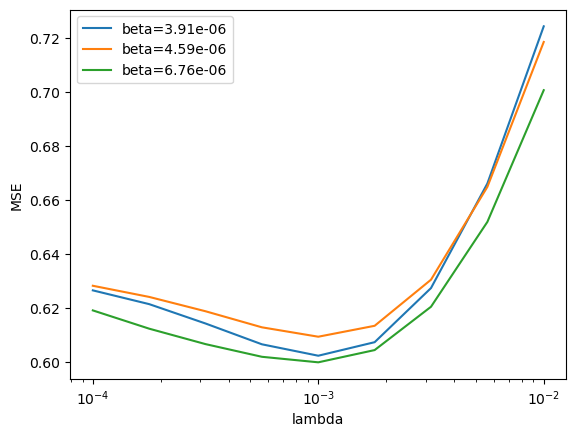

In [ ]:
#### TASK 2 CODE
# In order to make this task train in a reasonable amount of time, 
# and because concurrent.futures doesn't work in jupyter notebooks
# the work for this task is in task2_worker.py
# We just import the results in the pickle file
with open('hw5_task_2_cv_err.pkl', 'rb') as f:
    betas, lmbds, mses = pickle.load(f)
for i, beta in enumerate(betas):
    plt.plot(lmbds, mses[i], label=f'beta={beta:.2e}')
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.legend()
plt.show()
#### TASK 2 CODE

In [83]:
beta_id, lmbd_id = np.unravel_index(np.argmin(mses), mses.shape)
best_lmbd = lmbds[lmbd_id]
best_mse = mses.min()
best_beta = betas[beta_id]
null_mse = mean_squared_error(null_predictor(housing_data.X_train), housing_data.y_train)
mean_mse = mean_squared_error(mean_predictor(housing_data.y_train, housing_data.X_train), housing_data.y_train)
print(f"Kernel Ridge Regression MSE: {best_mse}, with lambda={best_lmbd}, and beta={best_beta}")
print(f"Null predictor MSE: {null_mse}")
print(f"Mean predictor MSE: {mean_mse}")

Kernel Ridge Regression MSE: 0.5999507877827186, with lambda=0.001, and beta=6.756091323973005e-06
Null predictor MSE: 5.575252963671465
Mean predictor MSE: 1.3331326837230717


## 2D kernel SVM

In this part, we see how SVM works on 2d data. We will walk through solving this problem using different kernels. You need to explore different kernels and parameter settings to understand the effect of the hyperparameters. We will use the [implementation of SVM in `scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) which does the following. You can find more details [here](https://scikit-learn.org/1.6/modules/svm.html#svc).

Given training vectors $x_i \in \mathbb{R}^p$, $i=1,\dots,n$, in two classes, and a vector $y \in \{1, -1\}^n$, our goal is to find $w \in \mathbb{R}^p$ and $b \in \mathbb{R}$ such that the prediction given by:

$$
\text{sign}(w^T \phi(x) + b)
$$

is correct for most samples.

SVC solves the following primal problem:

$$
\min_{w,b,\zeta} \quad \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i
$$

subject to:

$$
y_i (w^T \phi(x_i) + b) \geq 1 - \zeta_i,
$$

$$
\zeta_i \geq 0, \quad i = 1, \dots, n
$$

Intuitively, we're trying to maximize the margin (by minimizing $ \|w\|^2 = w^T w $), while incurring a penalty when a sample is misclassified or within the margin boundary. Ideally, the value $ y_i (w^T \phi(x_i) + b) $ would be $ \geq 1 $ for all samples, which indicates a perfect prediction. But problems are usually not always perfectly separable with a hyperplane, so we allow some samples to be at a distance $ \zeta_i $ from their correct margin boundary.

The penalty term $ C $ controls the strength of this penalty.

`svm.SVC` supports built-in **RBF, polynomial, and linear kernels**, which we have covered in class. To help you understand how they work, we implement a **polynomial kernel** below. You can also find the code for the **RBF kernel** at the beginning of the notebook.

To verify that everything works correctly, try using both **our defined kernel** and `SVC`'s built-in kernels and compare the results.

We have prepared three toy demo datasets, each containing 10 positive samples and 10 negative samples. You are encouraged to run SVM on each demo set and explore different **kernels**, **hyperparameters**, and **regularization settings** to understand how these factors influence the learned classifier.
- Spend some time analyzing the impact of these choices, as they will be critical in later sections.
- In the next part, you will work with **higher-dimensional data**, where visualization is not as straightforward. This makes it even more important to understand how hyperparameters affect your model now.

In [40]:
from utils import get_demo

def poly_kernel(degree = 2, beta = 1 , a = 1):
    def poly_kernel_inst(x1,x2):
        return (beta * x1@x2.T + a)**degree
    return poly_kernel_inst


def train_and_plot_svm(data, C=None, **args):
    svm_clf = svm.SVC(**args,C=C)
    svm_clf = svm_clf.fit(data.X_train, data.y_train)
    utils.plot_decision_boundary_with_svm(svm_clf, data.X_train, data.y_train, data.X_test, data.y_test, C=C)
    # utils.plot_decision_boundary_with_svm(svm_clf, data.X_train, data.y_train, None, None, C=C)
    # you can also avoid passing C by checking for margin violations based on the response being less then 1
    if data.y_test is not None:
        data.print_errors(svm_clf)
    return svm_clf

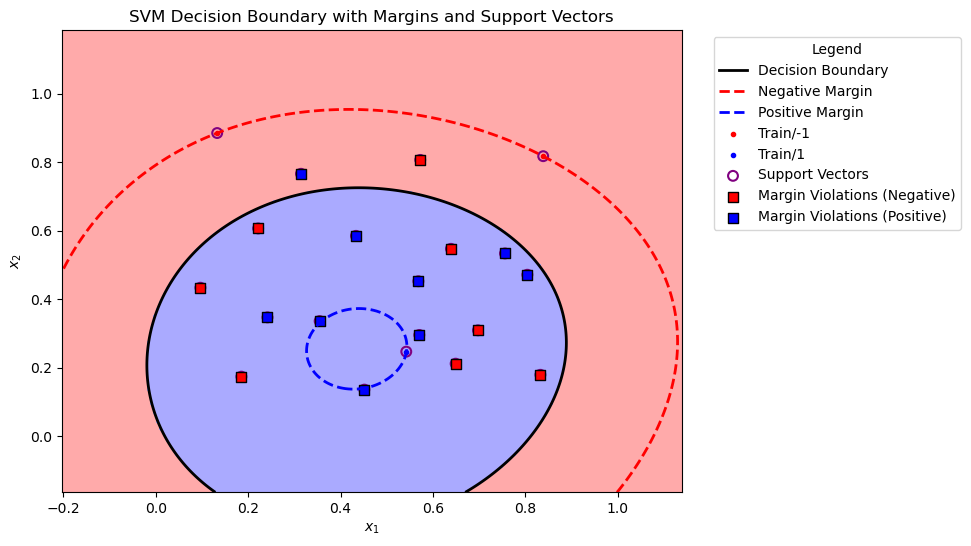

In [41]:
 # Select demo by choosing 1, 2, or 3
demo = get_demo(3)  # Change the number (1, 2, or 3) to load a different demo

# Set hyperparameters for the SVM model
C = 5
gamma = 1

# Train and plot SVM using a custom RBF kernel (default option)
svm_clf = train_and_plot_svm(demo, C=C, kernel=RBF_kernel(beta=gamma))

# Alternative: Use the built-in RBF kernel from sklearn's SVC (if needed)
# Uncomment the line below to use sklearn's built-in RBF kernel instead of the custom one
# svm_clf = train_and_plot_svm(demo, C=C, kernel='rbf', gamma=gamma)

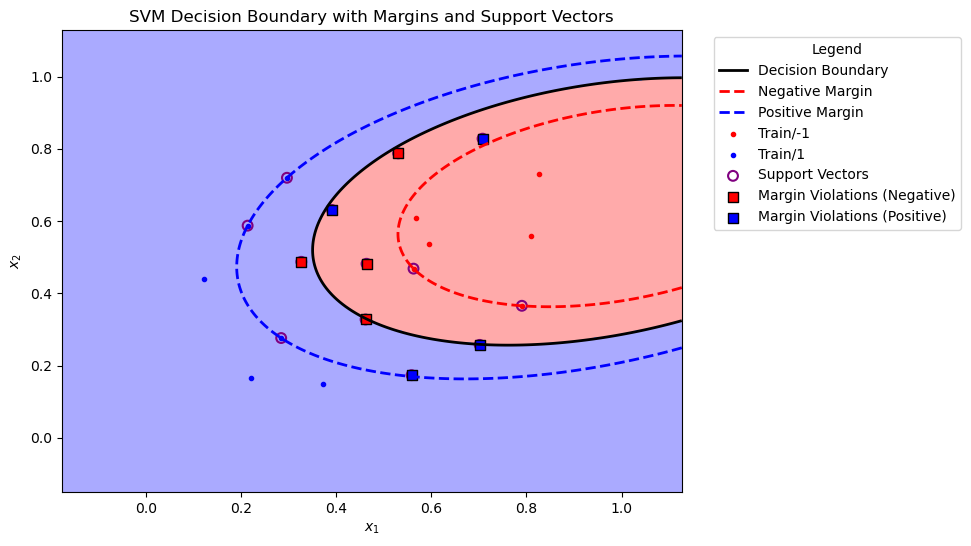

In [42]:
# Select demo by choosing 1, 2, or 3
demo = get_demo(1)  # Change the number to load a different demo

# Set SVM hyperparameters
C = 5
degree = 3
beta = 2
a = 1

# Train and plot SVM using the custom polynomial kernel (default)
svm_clf = train_and_plot_svm(demo, C=C, kernel=poly_kernel(degree=degree, beta=beta, a=a))

# Alternative: Use the built-in polynomial kernel from sklearn's SVC
# Uncomment the line below to use sklearn's polynomial kernel instead of the custom one
# svm_clf = train_and_plot_svm(demo, C=C, kernel='poly', degree=degree, gamma=beta, coef0=a)

Now we will move from toy demo data to spiral dataset that you are very familiar with. 

In [43]:
np.random.seed(0)

LABELS = [-1, 1]
SP_THETA_SIGMA = 0.3
SP_R_SIGMA = 0.05
NOISE_LEVEL = 0.2

m = 1000
Xsp, ysp = utils.generate_spiral_data(m, noise_level=NOISE_LEVEL, theta_sigma=SP_THETA_SIGMA, r_sigma=SP_R_SIGMA)

train_test_ratio = 0.8
Xsp_train, ysp_train, Xsp_test, ysp_test = utils.create_split(Xsp, ysp, train_test_ratio)

spirals = TrainAndTestData(Xsp_train, ysp_train, Xsp_test, ysp_test)

Explore how the **RBF kernel** performs on the spiral dataset by varying gamma(beta) and observing its effect on the decision boundary.  
- Try **different values of gamma**, including extreme ones, to understand how it influences model behavior.  
- You can find more details on **gamma in the RBF kernel** [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#rbf-kernel).

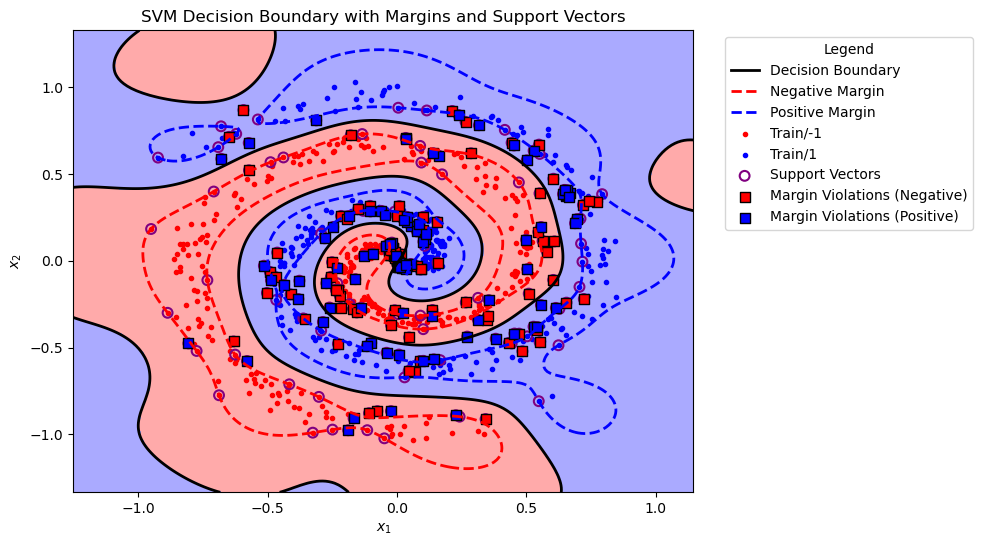

Train error: 9.00%
Test error: 6.00%


In [44]:
# Set hyperparameters for the SVM model

C = 5       
gamma = 10

# Train and plot SVM using a custom RBF kernel (default option)
svm_clf = train_and_plot_svm(spirals, C=C, kernel=RBF_kernel(beta=gamma))

# Alternative: Use the built-in RBF kernel from sklearn's SVC (if needed)
# Uncomment the line below to use sklearn's built-in RBF kernel instead of the custom one
# svm_clf = train_and_plot_svm(spirals, C=C, kernel='rbf', gamma=gamma)

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 2]</h4>
How does the choice of gamma affect the decision boundary? What happens when gamma is set to very high or very low values?
<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">

Answer: When gamma is very small the decision boundary is far more linear, in the sense of the domain. When gamma is very high, the decision boundary is far more squiggly. 

</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

See how polynoimal kernel works on the spiral data. You should try different numbers for degree, scaling factor gamma(beta) and bias term a to see how the decision boundard looks like. The hyperparameters are defined [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#polynomial-kernel)

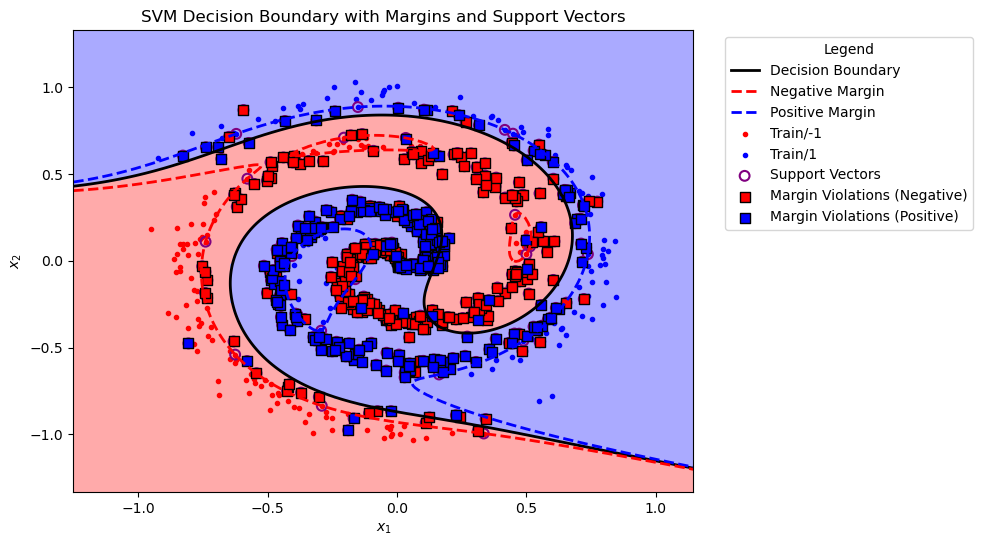

Train error: 26.00%
Test error: 27.50%


In [45]:
# Set SVM hyperparameters
C = 5
degree = 5
gamma = 1
a = 1

# Train and plot SVM using the custom polynomial kernel (default)
svm_clf = train_and_plot_svm(spirals, C=C, kernel=poly_kernel(degree=degree, beta=gamma, a=a))

# Alternative: Use the built-in polynomial kernel from sklearn's SVC
# Uncomment the line below to use sklearn's polynomial kernel instead of the custom one
# svm_clf = train_and_plot_svm(spirals, C=C, kernel='poly', degree=degree, gamma=gamma, coef0=a)

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 3]</h4>
How does the choice of degree, scaling factor gamma(beta) and bias term a affect the decision boundary?
<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">

Answer: When the degree is high, the training takes longer and the generalization error increases due to overfitting, but since the training error massively decreases, the generalization error also decreases. For small gamma, the decision boundary gets closer to linear. For large gamma, the decision boundary becomes not linear. As a increases the eccentricity of the decision boundary increases.

</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

### [Task 3] Applying SVM classifiers to the 2D spiral data
For the classifier you trained, you need to finish code below to compute training loss, training error, margin violations and the number of support vectors.

In [ ]:
#### TASK 3 CODE
# training loss: hinge loss of svm_clf
train_loss = np.mean(np.maximum(0, 1 - svm_clf.decision_function(Xsp_test) * ysp_test))
print(f"Hinge loss: {train_loss}")

# training error
train_err = 1 - svm_clf.score(Xsp_test, ysp_test)
print(f"Train error: {train_err}")

# margin violations
margin_violations = np.sum(svm_clf.decision_function(Xsp_test) * ysp_test < 1)
print(f"Margin violations: {margin_violations}")

# number of support vectors
num_support_vectors = np.sum(svm_clf.n_support_)
print(f"Number of support vectors: {num_support_vectors}")
print(f"Decision of support vectors that are not on the margin and are not margin violations: {
    svm_clf.decision_function(
        Xsp_train[svm_clf.support_][svm_clf.decision_function(Xsp_train[svm_clf.support_]) * ysp_train[svm_clf.support_] > 1]
    )
    }"
)
# note: there are support vectors that are not margin violations, or are on the margin!
#### TASK 3 CODE

Hinge loss: 0.6672551965820905
Train error: 0.275
Margin violations: 147
Number of support vectors: 596
Decision of support vectors that are not on the margin and are not margin violations: [-1.00003132 -1.00032295 -1.00036058 -1.00009841 -1.0004729  -1.00017488
 -1.00005408  1.00002004  1.00046354  1.00024962  1.00008058  1.00029977
  1.00042147  1.00035495]


<span style="color: red">
<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: We find that the hinge loss is 0.667, the train error is 0.275, the number of margin violations is 147, and the number of support vectors is 596. What's notable is that there are multiple vectors that are classed as support vectors that are not in fact support vectors!
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

## Sentiment Analysis Using Kernel SVM

Next, we will develop a sentiment classifier using kernel SVM. We will work with a real-world dataset of [tweets to airlines](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/version/2). Datasets that have been scraped from the internet (such as this one) are prone to many issues, whether we use them directly or with some filtering. See if you can think of a few potential issues, and feel free to discuss with TAs at office hours. Despite these issues, the dataset provides value in giving us short statements with strong sentiment that we will build a classifier over.

**Data pre-processing** The raw data, which you can access and study at the above link, contains 15 attributes, including `tweet_id` , `airline_sentiment`, `negative_reason`, `airline`, `text.` Of these, we are most interested in `airline_sentiment` and `text`. To that end, we have extracted these for you in the files `cleaned_tweets_train.tsv`. A `tsv` file is a file where the different attributes are separated by tabs. The dataset identifies three different sentiments: `positive`, `neutral`, and `negative`. After extracting just the tweets and the sentiments, we shuffled all the tweets and saved the first 3/4 of them to the training file and the remaining 1/4 of them to the test file.

**Data loading** The `load_data` function we provide in `utils.py` allows filtering neutral (i.e., removing them from the data) by setting `filter_neutrals` flag to `True` or including them but counting them as "not positive" examples by setting `filter_neutrals` flag to `False`.

In [70]:
!mkdir data
import gdown
gdown.download(f"https://drive.google.com/uc?id=1acMRrRzHQdni-WVtMZOTwOEQGmcGWvcM", "./data/cleaned_tweets_train.tsv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id=1S_o4sBJs2uWJfEPLsykzsgBM8gYx_gzw", "./data/cleaned_tweets_test.tsv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1acMRrRzHQdni-WVtMZOTwOEQGmcGWvcM
To: c:\Users\matth\OneDrive\Documents\School\Senior Year\Winter Quarter\TTIC 31020\hw5\data\cleaned_tweets_train.tsv
100%|██████████| 1.08M/1.08M [00:00<00:00, 11.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S_o4sBJs2uWJfEPLsykzsgBM8gYx_gzw
To: c:\Users\matth\OneDrive\Documents\School\Senior Year\Winter Quarter\TTIC 31020\hw5\data\cleaned_tweets_test.tsv
100%|██████████| 279k/279k [00:00<00:00, 5.05MB/s]


'./data/cleaned_tweets_test.tsv'

### Kernel Functions

Recall that a kernel can be defined as $K_{ij} = \langle \phi(x_i), \phi(x_j) \rangle\, \in \mathbb{R}\,.$ However, the $x_i$ does not have to be real-valued, or numeric at all. Indeed, in this case, they are strings of length $k$ (tweets, in particular) in $\mathcal{D}^k$, where $\mathcal{D}$ is the dictionary of words. Then, we can decompose the kernel as:


$$
K_{ij} = \langle \phi(x_i), \phi(x_j) \rangle = \langle \tilde{\phi}(v(x_i)), \tilde{\phi}(v(x_j))\rangle\
$$


where $\phi = \tilde{\phi} \circ v\,,$ $\tilde{\phi} \, : \mathbb{R}^{d_1} \mapsto \mathbb{R}^{d_2}$ and $v \, : \mathcal{D}^k \mapsto \mathbb{R}^{d_1}\,.$

This decomposition allows us to separate the transformation into two parts. Now, we can choose both independently. Here are some suggestions for each:

* For $v(x_i)\,:$
    * **Bag-of-words**: for each word $w$ in the corpus, the corresponding component of the bag-of-words representation of $x_i$ is defined as the number of occurences of $w$ in $x_i$.
    * **Bi-gram**: for each pair of words that occur contiguously in the corpus, the corresponding component of the bi-gram representation of $x_i$ is the number of times that the bi-gram (two-word pattern) appears in $x_i$.
    * **Subsequence counts**: for each subsequence (of fixed size) in the corpus, the corresponding component of this representation of $x_i$ is the number of times that the subsequence has appeared in the document $x_i.$ (A subsequence allows for skipping characters, whereas a substring is all continguous characters.)
    * ...others?



* For $\tilde{\phi}\,:$
    * Linear
    * Polynomial
    * Radial basis function
    * Weighted cosine similarity
    * ...others?

**Check your understanding**:
* what is the dimension of a bag-of-words representation of a sentence? what about bigram?

In [62]:
def BoW_inner(s1,s2):
    "returns inner product between bag-of-word feature vectors of the two input strings"
    from collections import Counter
    d1 = Counter(s1.split())
    return sum(d1[w] for w in s2.split())

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 4]</h4>

No coding in this one: Consider the BoW kernel constructed in `BoW_inner`. Suppose there are $D$ words in the corpus, and each sentence (document) has at most $k$ words.
* What is the time and space complexity of naively constructing the bag-of-words vector for each sentence and computing their inner product?
* What is the time and space complexity of the implementation in the code?
* What accounts for the difference? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">

Answer: We take the following naiive implementation:
* Initialize empty vector $v_1$ with $D$ elements.
* Iterate over $s_1$ and increment the component of $v_1$ corresponding to each word in $s_1$. 
* Do the same for $s_2$.
* Take the inner product of $v_1$ and $v_2$

The time complexity of vectorizing $s_1$ is $O(k)$ and the space complexity is $O(D)$. The time complexity to compute the inner product is then
$$
O(2k) + O(D + D-1) = O(K + D)
$$
The space complexity is 
$$
O(2D) + O(1) = O(D)
$$

The time complexity of $s_1.split()$ is $O(n)$, where $n$ is the length of $s_1$. It is assumed that the length of words is bounded, so $s_1.split()$ is $O(k)$. The space complexity of it is $O(k)$. Counter() is also $O(k)$, since $k$ is the length of the list. This uses the same space as $s_1.split()$. Accessing $d1$ is $O(1)$, and $s_2.split()$ is also $O(k)$, time and space complexity. Since we perform $k$ $O(1)$ accessing operations and $k-1$ addition operations, we have that the time and space complexity of the implemented method is $O(k)$.

The difference is in the fact that when we compute the inner product in the naiive implementation, we iterate over a list of length $d$, instead of just accessing the non-zero elements right away. 
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

### [Task 4] Implementing your own feature mapping function for text data

Think about your own understanding of sentences. What features do you use to understand them? **Hand design a feature mapping from sentence to numeric values that might help a kernel learn to classify sentiment.** To do this, you may wish to load the training data and inspect what positive and negative samples look like.

In [22]:
X_train, y_train = utils.load_data(os.path.join(os.getcwd(),"data/cleaned_tweets_train.tsv"),type="train")
y_train = np.array(y_train)

In [3]:
print("---- positive samples ----")
for i in range(100):
    if y_train[i] == 1:
        print(X_train[i])
print("--------------------------")
print("---- negative samples ----")
for i in range(100):
    if y_train[i] == -1:
        print(X_train[i])
print("--------------------------")

---- positive samples ----
@united flight 1491...plane from SFO to DEN is basically on time.
@united thank you for getting our daughter home when @americanair Cancelled Flightled all their flights to Nashville
"@united sweet
@united thanks for not getting my BusinessFirst priority tagged bag onto my connecting flight at EWR despite a 2+ hour layover. Nice job
@united man I can't wait to book my ticket now! Thanks JP you're a life sabe
@JetBlue thanks so much for your condolences and quick response. It is very much appreciated
@JetBlue Thanks for the $100 credit because of the 4hr delay. I can tell customer service means a lot to YOU #Thankful
@SouthwestAir is the best airline out there no one is better than them #OneLove #Southwest #bestairline
@united My favorite way to travel! Thank you! http://t.co/vGN2X1ckg0
@USAirways Kudos to Robin at @PHXSkyHarbor Lost/Found for reuniting me w/ my iPad. She was delightful to work with!
@SouthwestAir thanks for getting me back to Nashville. Big t

In [4]:
def emotion_dimensions(x1): ### You should rename this to be more descriptive about the feature mapping that you are using
    #### TASK 4 CODE
    # This is an open question, so we will not provide a fixed solution, but you
    # are encouraged to share your ideas in the course discussion over Canvas!
    #### TASK 4 CODE
    # The emotional dimensions we use are: 
    # Gratitude, Comfort, Impression/Perceived Competency, and Fun/Joy. 
    # We also have two dimensions for excitement and confusion, which are determined by exclamation marks or question marks.
    # We use bigrams to capture negations, i.e. I was not happy -> -negative joy.
    # Each word is associated with a vector and a signed quantity in each emotional dimension.
    # We sum each word vector in the tweet, and normalize by the number of words we are giving non-zero emotions to in the tweet.


    # We map contractions to their respective logical value: i.e. wasn't -> not
    contractions = {"wasn't", "won't", "aren't", "isn't", "weren't", "wouldn't", "can't", "couldn't", "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "shouldn't"}
    # word lists
    negations = {"not", "no", "never", "neither", "nor", "nobody", "none", "nothing", "nowhere", "hardly", "scarcely", "barely"}
    gratitude = {"thanks", "thank", "thankful", "appreciated", "appreciate", "appreciate", "appreciates", "ty", "thx", "kudos", "bless", "blessed", "blessing", "grateful", "gratitude", "like", "liked", "likes", "love", "loved", "loves", "loving", "amazing", "awesome", "good", "great", "excellent", "wonderful", "fantastic", "superb", "terrific", "fabulous", "fab"}
    comfort = {"time", "best", "favorite", "made", "rescued", "rescue", "safe", "safety", "safe", "safely", "comfort", "comfortable", "comforting", "comforted", "relax", "relaxed", "relaxing", "relaxation", "empathy", "important"}
    competency = {"impress", "impressed", "impressive", "capable", "capably", "skill", "skillfull", "skillfully", "skilled", "talent", "talented", "resolve", "resolution", "resolved"}
    fun = {"fun", "funny", "hilarious", "laugh", "laughed", "laughing", "laughable", "joke", "joking", "joked", "jokes", "enjoy", "enjoyed", "enjoying", "enjoyable", "enjoyment", "entertain", "entertained", "entertaining", "entertainment", "excite", "excited", "exciting", "excitement", "thrill", "thrilled", "thrilling", "thrills", "joy", "joyful", "joyous", "joyed", "happy", "happiness", "happily", "happier", "happiest", "smile", "smiled", "smiling", "smiles"}
    gratitude_neg = {"worst", "awful", "cancelled", "cancel", "canceling", "wait", "waiting", "waited", "waiting", "waste", "wasted", "wasting", "wastes", "wasteful", "wastefully", "disappointed", "disappointing", "bored", "hold", "delay", "delayed", "hung", "hang"}
    comfort_neg = {"frustrated", "frustrating", "frustrate", "frustrates", "frustration", "stress", "stressed", "stressful", "stressfully", "anxious", "anxiety", "anxiously", "anxieties", "nervous", "nervously", "issue"}
    competency_neg = {"late", "where", "worthless", "pointless", "stupid", "dumb", "bad", "awful", "terrible", "horrible", "disgusting", "rude", "inconsiderate", "remove", "removed", "errors", "removing", "mistake", "incompetent", "loser", "bad", "lost", "losing", "lose", "ridiculous", "insane", "suck", "waiting", "waited", "wait", "waste", "wasted", "wasting", "wastes", "wasteful", "wastefully", "disappointed", "disappointing", "bored", "hold", "delay", "delayed", "hung", "hang"}
    fun_neg = {"bored", "lame", "lazy", "unfun", "tired", "sleepy", "exhausted"}
    # basis vectors:
    emotions = {
        1: gratitude,
        2: competency,
        3: comfort,
        4: fun,
        -1: gratitude_neg,
        -2: comfort_neg,
        -3: competency_neg,
        -4: fun_neg
    }
    basis = {
        1: np.array([1, 0, 0, 0, 0, 0]),
        2: np.array([0, 1, 0, 0, 0, 0]),
        3: np.array([0, 0, 1, 0, 0, 0]),
        4: np.array([0, 0, 0, 1, 0, 0]),
        -1: np.array([-1, 0, 0, 0, 0, 0]),
        -2: np.array([0, -1, 0, 0, 0, 0]),
        -3: np.array([0, 0, -1, 0, 0, 0]),
        -4: np.array([0, 0, 0, -1, 0, 0])
    }

    # process tweet 
    v = np.zeros(6)
    excitement = 2 * int('!' in x1) - 1
    confusion = 2 * int('?' in x1) - 1
    words = x1.split()
    words = list(map(lambda x: x.lower(), words))
    words = [w.split('?') for w in words]
    from itertools import chain
    words = list(chain.from_iterable(words))
    words = [w.split('!') for w in words]
    words = list(chain.from_iterable(words))
    num_detected = 0
    for i, word in enumerate(words):
        neg = 1
        if (i > 0):
            neg = 2 * int(words[i-1] in negations or words[i-1] in contractions) - 1
        for emotion in emotions:
            if word in emotions[emotion]:
                num_detected += 1
                v += -neg * basis[emotion]
    if num_detected > 0:
        v /= num_detected
    v[4] = excitement * num_detected/len(words)
    v[5] = confusion * num_detected/len(words)

    return v

In [5]:
def my_inner_product(x1, x2):
    '''
    this function computes the inner product phi(x1)*phi(x2) for phi,
        the feature transform defined in the previous cell, i.e., my_feature_map
    implementing this as np.dot(my_feature_map(x1), my_feature_map(x2)) is not
        super-useful, as the runtime will be at least linear in the dimension of
        the feature map. Instead, implement this without ever using my_feature_map.
    '''
    #### TASK 4 CODE
    # This is an open question, so we will not provide a fixed solution, but you
    # are encouraged to share your ideas in the course discussion over Canvas!
    #### TASK 4 CODE
    return np.dot(emotion_dimensions(x1), emotion_dimensions(x2))

Next, we compute the Gram matrix from any kernel we have implemented (e.g., the one you just implemented or the bag-of-words example given in function `BoW_inner`. This is useful in computing $\tilde{\phi}$ for $\tilde{\phi}$ that can be vectorized.

In [58]:
def gram_matrix(K):
    def gram_matrix_K(xs_1, xs_2):
        return np.array([[K(x1, x2) for x2 in xs_2] for x1 in xs_1])
    return gram_matrix_K

In [59]:
def rbf_kernel_gram(inner, beta=1):
    """Gaussian RBF kernel.

    Returns a functoin gram(xs_1,xs_2) that calculate the (cross) gram matrix G[i,j]=K(xs_1[i],xs_2[j]])
    where K is the Gaussian RBF on the features phi, specified through the inner product in phi space."""
    def rbf_kernel_sigma_inner(xs_1,xs_2):
        return np.exp(-beta*(np.array([inner(x1, x1) for x1 in xs_1])[:, np.newaxis]
                             + np.array([inner(x2, x2) for x2 in xs_2])
                             - 2*gram_matrix(inner)(xs_1, xs_2)))
    return rbf_kernel_sigma_inner

In [60]:
def poly_kernel_gram(inner, deg, alpha=1.0):
    def poly_kernel_deg_alpha(xs_1, xs_2):
        return (alpha + gram_matrix(inner)(xs_1, xs_2))**deg
    return poly_kernel_deg_alpha

Let us see how to generate the RBF kernel matrix using `BoW_inner` and `my_inner_product` as $\langle v(x_i), v(x_j)\rangle$ for some value of the parameter $\beta\,.$ Note that `rbf_kernel_gram(inner, beta)` returns a function, and we pass it the datasets as arguments.

In [22]:
xi = X_train[1]
rbf_kernel_gram(BoW_inner,0.2)([xi],X_train[5:12]).shape

(1, 7)

In [23]:
rbf_kernel_gram(my_inner_product,0.2)(X_train[:10],X_train[5:12])

array([[0.99955565, 0.81645966, 0.71900362, 0.84810556, 0.81645966,
        0.89704009, 0.90232747],
       [0.85049385, 0.91003571, 0.75740805, 0.93326664, 0.91003571,
        0.90389719, 0.9304851 ],
       [0.81791243, 1.        , 0.88063582, 0.94668119, 1.        ,
        0.89953533, 0.89483932],
       [0.81791243, 1.        , 0.88063582, 0.94668119, 1.        ,
        0.89953533, 0.89483932],
       [0.81791243, 1.        , 0.88063582, 0.94668119, 1.        ,
        0.89953533, 0.89483932],
       [1.        , 0.81791243, 0.72028298, 0.8452688 , 0.81791243,
        0.89863624, 0.89992447],
       [0.81791243, 1.        , 0.88063582, 0.94668119, 1.        ,
        0.89953533, 0.89483932],
       [0.72028298, 0.88063582, 1.        , 0.83368136, 0.88063582,
        0.80767614, 0.78802755],
       [0.8452688 , 0.94668119, 0.83368136, 1.        , 0.94668119,
        0.96014607, 0.97994093],
       [0.81791243, 1.        , 0.88063582, 0.94668119, 1.        ,
        0.89953533, 0.8

### [Task 5] Optimizing your SVM classifier

Now that we know how to extract and kernelize our data, let us train SVM on it. As an example, here is how you might use `sklearn`'s SVM implementation:

In [ ]:
# fit svm with a small subset of data
svm_clf = svm.SVC(kernel=poly_kernel_gram(BoW_inner, 2))
svm_clf= svm_clf.fit(X_train[:100], y_train[:100])
preds = svm_clf.predict(X_train[100:120])
print(preds)

[-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1]


Here, poly_kernel_gram computes the polynomial kernel matrix on the fly. This means that every time `SVC` is called, it must re-compute all pairwise inner products between feature vectors. While this approach is fine for small datasets, it becomes computationally expensive for large-scale problems. 
### Using a Precomputed Kernel

To improve efficiency, we can **precompute the kernel matrix** before passing it to `SVC`. This allows us to reuse the computed values instead of recalculating them multiple times.

#### How Precomputed Kernels Work in SVM

- Instead of providing raw feature vectors to `SVC`, we **compute and store the Gram matrix** (a matrix of pairwise similarities).
- This Gram matrix replaces the need for direct feature input.
- The model expects a **square matrix** for training (size $ n \times n$), where each entry represents the kernel function applied to a pair of training samples.
- During testing, we compute a **test vs. train kernel matrix** (size $ m \times n $) to compare new samples against the training set.

Below is the example and you will see it gives the same prediction as above. 

In [ ]:
# Compute the Gram matrix for training
K_train = poly_kernel_gram(BoW_inner, 2) (X_train[:100], X_train[:100])

# Train SVM using the precomputed kernel matrix
svm_clf = svm.SVC(kernel='precomputed')
svm_clf.fit(K_train, y_train[:100])

# Compute the Gram matrix for testing 
K_test = poly_kernel_gram(BoW_inner, 2) (X_train[100:120], X_train[:100]) # Notice: X_test vs X_train

# Predict using the precomputed test kernel
preds = svm_clf.predict(K_test)
print(preds)

[-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1]


In [ ]:
# fit svm with entire training data
# it can take several minutes to run
svm_clf = svm.SVC(kernel=poly_kernel_gram(BoW_inner, 2))
svm_clf= svm_clf.fit(X_train, y_train)
preds = svm_clf.predict(X_train)

In [ ]:
print(f"The training error is {np.mean(preds != y_train) * 100}%")

The training error is 0.2900232018561485%


Note that $C = 1/\lambda\,,$ where $\lambda$ is the regularization parameter we discussed in class. Use a validation set to evaluate the performance of the classifiers you train.

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 5]</h4>


<!-- <h4 style="font-weight: bold">---------------------</h4> -->

We give you a set of questions below to explore and some direction regarding how to explore them. As your "answer" for this section, submit a write-up in the notebook with 2-3 plots about the answers to these questions. Also submit your code as applicable. You can finish them with a small subset of training data but you are encouraged to try the entire training dataset with the precomputed kernel trick. 

* For different kernels, train SVM with different $\lambda$ spanning a good range. Use cross validation to determine a good value of $\lambda$. What are the resulted (1) 0-1, Hinge training loss? (2) Margin loss? (3) Test error? (4) Support Vectors? If using a precomputed kernel, cross-validation requires special handling. Since the Gram matrix depends on the training set, you need to extract the corresponding submatrices for each training split in cross-validation. The training submatrix should only include training samples, and the validation submatrix should compare validation samples against the training set.

* Identify examples where the classifier fails for different kernels. Speculate on what the various kernels might be more suited to.

* You implemented your own kernel: how did that do? Did the performance match what you were expecting? If not, what factors might have influenced that?

* Consider the various attributes of a machine learning algorithm we may be interested in practically: generalization, runtime, memory usage, ease of implementation, understandability. How does kernel SVM for the kernels you tried perform on each of these attributes?


<span style="color: blue">
Answer: 

* below

* below

* My kernel did okay, and it matched the performance I was expecting. I think there are some pretty basic limitations of hardcoded feature spaces with natural language processing. I just couldn't possibly add all the words I needed to.

* The generalization of the rbf was poorer than the poly model. The rbf also took far more time to compute the matrix for. However, cross-validating the rbf was easier, since it had one fewer parameter. One additional quirk of the poly model was that standardization of the gram matrix was necessary. Without standardizing, the smallest element of the gram matrix could be as large as 10^16! 
</span>




After evaluating different classifiers you developed based on various design choices, evaluate the performance of the one you've chosen to "ship". 

First, we evaluate my kernel function. 

In [ ]:
#fast gram matrix based of my inner product
emotion_dim_x_train = np.array([emotion_dimensions(x) for x in X_train])
my_gram = emotion_dim_x_train @ emotion_dim_x_train.T

In [34]:
# cross validation utility
def cross_val_svm(n, folds, X_train, y_train, kernel, c_low = -2, c_high = 2):
    errs = np.zeros(n)
    cs = np.logspace(c_low, c_high, num=n)
    for i, c in enumerate(cs):
        err = 0
        svm_clf = svm.SVC(C=c, kernel = 'precomputed', cache_size=1000)
        for j, (train_idxs, val_idxs) in enumerate(sklearn.model_selection.KFold(n_splits = folds).split(range(len(X_train)))):
            svm_clf.fit(kernel[train_idxs][:, train_idxs], y_train[train_idxs])
            preds = svm_clf.predict(kernel[val_idxs][:, train_idxs])
            err += np.mean(preds != y_train[val_idxs])
            print(f"Finished fold {j} with iteration {i}")
        errs[i] = err/folds
    return (cs, errs)

Finished iteration 0, with error 0.1324815898178463
Finished iteration 1, with error 0.1324815898178463
Finished iteration 2, with error 0.132249625076487
Finished iteration 3, with error 0.132249625076487
Finished iteration 4, with error 0.1324815898178463
Finished iteration 5, with error 0.1324815898178463
Finished iteration 6, with error 0.1327135545592056
Finished iteration 7, with error 0.1324815898178463
Finished iteration 8, with error 0.13340944878328356
Finished iteration 9, with error 0.1327135545592056


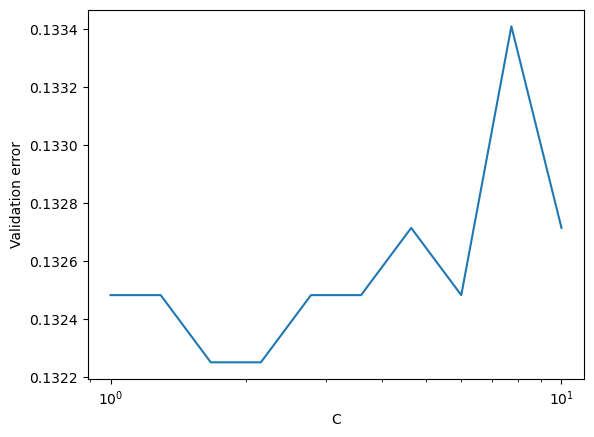

In [ ]:
# evaluate model
cs, errs = cross_val_svm(10, 3, X_train, y_train, my_gram, c_low = 0, c_high = 1)
plt.plot(cs, errs)
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Validation error')
plt.show()

In [ ]:
print(f"The best C for my own kernel is {cs[np.argmin(errs)]}, with an error of {np.min(errs)}")

The best C is 1.6681005372000588, with an error of 0.132249625076487


This error is pretty good, but let's try a few other kernels to see if we can get better. My kernel doesn't have many hyper-parameters, so it isn't very flexible, but for a hard-coded kernel it doesn't perform too bad.

Here we try the bag of words inner product with the gaussian rbf kernel to find the best hyper parameters of beta and C by cross-validation.

We compute the gram matrices in hw5_task_5_BoW_G_RBF.py. 

This is because multiprocessing is broken for interactive consoles, and not multiprocessing results in compute times of 30+ min on my machine, as opposed to 222.23 seconds with multiprocessing. 

We output the gram matrices into BoW_G_RBF_gram and read some here. These are large files, so we read them one at a time because my poor machine only has 16gb of ram.

In [162]:
"""
hw5_task_5_BoW_G_RBF_gram.py


import os
import numpy as np
import sklearn
from sklearn import svm
import matplotlib.pyplot as plt
import utils
import concurrent.futures
import pickle 
import sys
import time 

def BoW_inner(s1,s2):
    "returns inner product between bag-of-word feature vectors of the two input strings"
    from collections import Counter
    d1 = Counter(s1.split())
    return sum(d1[w] for w in s2.split())
def gram_matrix_worker(kernel, inner, beta, x1, x2):
    ker = kernel(inner, beta=beta)
    return ker(x1, x2)
def gram_matrix(K):
    def gram_matrix_K(xs_1, xs_2):
        return np.array([[K(x1, x2) for x2 in xs_2] for x1 in xs_1])
    return gram_matrix_K
def rbf_kernel_gram(inner, beta=1):
    Gaussian RBF kernel.

    Returns a functoin gram(xs_1,xs_2) that calculate the (cross) gram matrix G[i,j]=K(xs_1[i],xs_2[j]])
    where K is the Gaussian RBF on the features phi, specified through the inner product in phi space.
    def rbf_kernel_sigma_inner(xs_1,xs_2):
        return np.exp(-beta*(np.array([inner(x1, x1) for x1 in xs_1])[:, np.newaxis]
                             + np.array([inner(x2, x2) for x2 in xs_2])
                             - 2*gram_matrix(inner)(xs_1, xs_2)))
    return rbf_kernel_sigma_inner

if __name__ == '__main__':
    # init data
    X_train, _ = utils.load_data(os.path.join(os.getcwd(),"data/cleaned_tweets_train.tsv"),type="train")
    
    # init params
    beta_low = float(sys.argv[1])
    beta_high = float(sys.argv[2])
    n = int(sys.argv[3])
    betas = np.logspace(beta_low, beta_high, num=n)
    start = time.time()
    for beta in betas:
        if os.path.isfile(f'BoW_G_RBF_gram/BoW_G_RBF_gram_beta_{beta:.1e}.pkl'):
            continue
        BoW_G_RBF_gram = np.zeros((len(X_train), len(X_train)))
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = {executor.submit(gram_matrix_worker, rbf_kernel_gram, BoW_inner, beta, [x_i], X_train): i for i, x_i in enumerate(X_train)}
            for future in concurrent.futures.as_completed(futures):
                i = futures[future]
                try:
                    BoW_G_RBF_gram[i] = future.result()
                except Exception as exc:
                    print(f'generated an exception: {exc}')
        with open(f"BoW_G_RBF_gram/BoW_G_RBF_gram_beta_{beta:.1e}.pkl", 'wb') as f:
            pickle.dump(BoW_G_RBF_gram, f)
    end = time.time()
    print(f"Time taken: {end-start}")
"""

'\nhw5_task_5_BoW_G_RBF_gram.py\n\n\nimport os\nimport numpy as np\nimport sklearn\nfrom sklearn import svm\nimport matplotlib.pyplot as plt\nimport utils\nimport concurrent.futures\nimport pickle \nimport sys\nimport time \n\ndef BoW_inner(s1,s2):\n    "returns inner product between bag-of-word feature vectors of the two input strings"\n    from collections import Counter\n    d1 = Counter(s1.split())\n    return sum(d1[w] for w in s2.split())\ndef gram_matrix_worker(kernel, inner, beta, x1, x2):\n    ker = kernel(inner, beta=beta)\n    return ker(x1, x2)\ndef gram_matrix(K):\n    def gram_matrix_K(xs_1, xs_2):\n        return np.array([[K(x1, x2) for x2 in xs_2] for x1 in xs_1])\n    return gram_matrix_K\ndef rbf_kernel_gram(inner, beta=1):\n    Gaussian RBF kernel.\n\n    Returns a functoin gram(xs_1,xs_2) that calculate the (cross) gram matrix G[i,j]=K(xs_1[i],xs_2[j]])\n    where K is the Gaussian RBF on the features phi, specified through the inner product in phi space.\n    def 

In [88]:
with open('BoW_G_RBF_gram/BoW_G_RBF_gram_beta_1.0e+01.pkl', 'rb') as f:
    BoW_G_RBF_gram_beta_0_1 = pickle.load(f)
print(BoW_G_RBF_gram_beta_0_1)

[[1.00000000e+000 5.14820022e-131 6.71418429e-079 ... 2.66919022e-109
  1.13396656e-126 1.38389653e-087]
 [5.14820022e-131 1.00000000e+000 5.87928270e-105 ... 1.13396656e-126
  9.92959040e-153 5.87928270e-105]
 [6.71418429e-079 5.87928270e-105 1.00000000e+000 ... 1.47889751e-074
  3.04823495e-083 1.58042006e-061]
 ...
 [2.66919022e-109 1.13396656e-126 1.47889751e-074 ... 1.00000000e+000
  1.21181048e-113 1.47889751e-074]
 [1.13396656e-126 9.92959040e-153 3.04823495e-083 ... 1.21181048e-113
  1.00000000e+000 1.29499819e-100]
 [1.38389653e-087 5.87928270e-105 1.58042006e-061 ... 1.47889751e-074
  1.29499819e-100 1.00000000e+000]]


We now cross-validate for beta and c in hw5_task_5_BoW_G_RBF_CV.py for the same reasons as before.

In [163]:
""" 
hw5_task_5_BoW_G_RBF_CV.py

import os
import numpy as np
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn import svm
import matplotlib.pyplot as plt
import utils
import concurrent.futures
import pickle 
import sys
import time

def cross_val_worker(clf, kernel, y_train, train_idxs, val_idxs):
    clf.fit(kernel[train_idxs][:, train_idxs], y_train[train_idxs])
    preds = clf.predict(kernel[val_idxs][:, train_idxs])
    return np.mean(preds != y_train[val_idxs])
def cross_val_svm(folds, y_train, kernel, cs, beta=1):
    err = np.zeros_like(cs)
    svms = [svm.SVC(C=c, kernel = 'precomputed', cache_size=100) for c in cs]
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = {
            executor.submit(cross_val_worker, svm_clf, kernel ** beta, y_train, train_idxs, val_idxs): (i,j) 
            for i, svm_clf in enumerate(svms)
            for j, (train_idxs, val_idxs) in enumerate(sklearn.model_selection.KFold(n_splits = folds).split(range(len(y_train))))
        }
        for future in concurrent.futures.as_completed(futures):
            i, _ = futures[future]
            err[i] += future.result()/folds
    return err
if __name__ == "__main__":
    # init data
    _, y_train = utils.load_data(os.path.join(os.getcwd(),"data/cleaned_tweets_train.tsv"),type="train")
    y_train = np.array(y_train)
    # fetch parameters
    beta_low = float(sys.argv[1])
    beta_high = float(sys.argv[2])
    c_low = float(sys.argv[3])
    c_high = float(sys.argv[4])
    n = int(sys.argv[5])
    folds = int(sys.argv[6])
    # init parameters
    betas = np.logspace(beta_low, beta_high, num=n)
    cs = np.logspace(c_low, c_high, num = n)
    errs = np.zeros((n, n))
    # train and evaluate
    start = time.time()
    for i, beta in enumerate(betas):
        with open(f'BoW_G_RBF_gram/BoW_G_RBF_gram_beta_{beta:.1e}.pkl', 'rb') as f:
            BoW_G_RBF_gram = pickle.load(f)
        err = cross_val_svm(folds, y_train, BoW_G_RBF_gram, cs, beta = beta)
        errs[i] = err
    with open(f'BoW_G_RBF_CV/BoW_G_RBF_CV_beta_{beta_low}_{beta_high}_C_{c_low}_{c_high}_n_{n}_folds_{folds}.pkl', 'wb') as f:
        pickle.dump((cs, betas, errs), f)
    end = time.time()
    print(f'Time taken: {end - start}')
"""

' \nhw5_task_5_BoW_G_RBF_CV.py\n\nimport os\nimport numpy as np\nimport sklearn\nfrom sklearn.datasets import fetch_california_housing\nfrom sklearn import svm\nimport matplotlib.pyplot as plt\nimport utils\nimport concurrent.futures\nimport pickle \nimport sys\nimport time\n\ndef cross_val_worker(clf, kernel, y_train, train_idxs, val_idxs):\n    clf.fit(kernel[train_idxs][:, train_idxs], y_train[train_idxs])\n    preds = clf.predict(kernel[val_idxs][:, train_idxs])\n    return np.mean(preds != y_train[val_idxs])\ndef cross_val_svm(folds, y_train, kernel, cs, beta=1):\n    err = np.zeros_like(cs)\n    svms = [svm.SVC(C=c, kernel = \'precomputed\', cache_size=100) for c in cs]\n    with concurrent.futures.ProcessPoolExecutor() as executor:\n        futures = {\n            executor.submit(cross_val_worker, svm_clf, kernel ** beta, y_train, train_idxs, val_idxs): (i,j) \n            for i, svm_clf in enumerate(svms)\n            for j, (train_idxs, val_idxs) in enumerate(sklearn.model_se

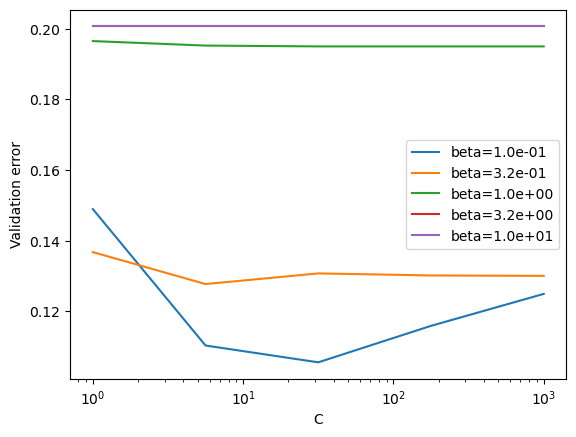

In [94]:
with open('BoW_G_RBF_CV/BoW_G_RBF_CV_beta_-1_1_C_0_3_n_5_folds_5.pkl', 'rb') as f:
    cs, betas, errs = pickle.load(f)
for i, beta in enumerate(betas):
    plt.plot(cs, errs[i], label = f'beta={beta:.1e}')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Validation error')
plt.legend()
plt.show()

This leads us to conclude that smaller values of beta and larger values of C are more effective for our BoW Gaussian RBF SVM. We will run this simulation again, but adjusting the ranges for beta and C. We will have beta in logspace(-2,-1) and C in logspace(0, 2)

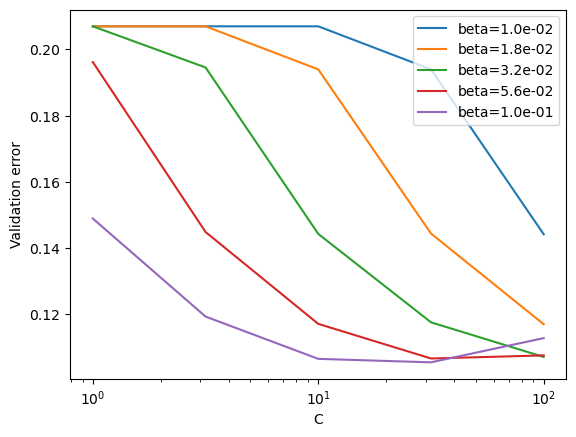

The best error achieved is 0.10556844547563805


In [99]:
with open('BoW_G_RBF_CV/BoW_G_RBF_CV_beta_-2.0_-1.0_C_0.0_2.0_n_5_folds_5.pkl', 'rb') as f:
    cs, betas, errs = pickle.load(f)
for i, beta in enumerate(betas):
    plt.plot(cs, errs[i], label=f'beta={beta:.1e}')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Validation error')
plt.legend()
plt.show()
print(f'The best error achieved is {np.min(errs)}')

We further refine our cross-validation:

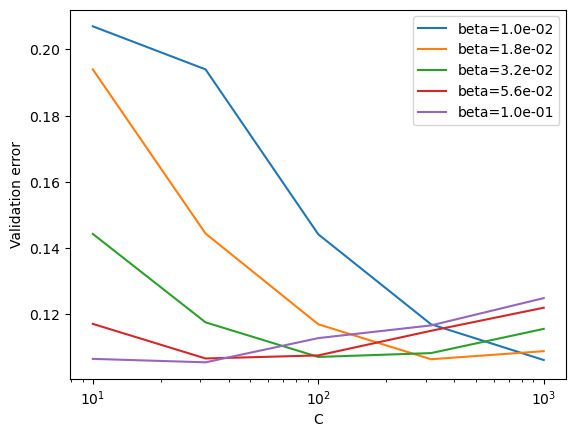

The minimum error is 0.10556844547563807


In [98]:
with open('BoW_G_RBF_CV/BoW_G_RBF_CV_beta_-2.0_-1.0_C_1.0_3.0_n_5_folds_5.pkl', 'rb') as f:
    cs, betas, errs = pickle.load(f)
for i, beta in enumerate(betas):
    plt.plot(cs, errs[i], label=f'beta={beta:.1e}')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Validation error')
plt.legend()
plt.show()
print(f'The minimum error is {np.min(errs)}')

With our last pass, we have the following results.

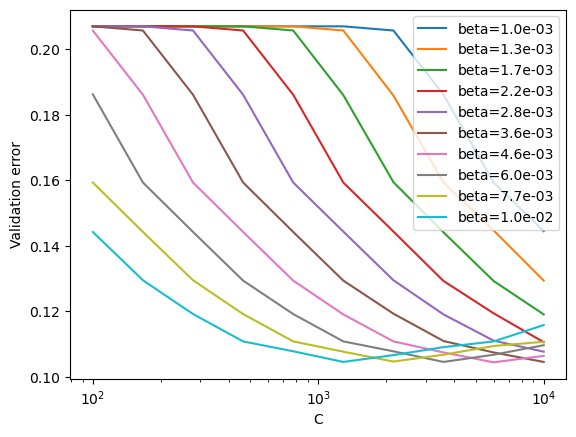

The minimum error is 0.10440835266821345


In [100]:
with open('BoW_G_RBF_CV/BoW_G_RBF_CV_beta_-3.0_-2.0_C_2.0_4.0_n_10_folds_5.pkl', 'rb') as f:
    cs, betas, errs = pickle.load(f)
for i, beta in enumerate(betas):
    plt.plot(cs, errs[i], label=f'beta={beta:.1e}')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Validation error')
plt.legend()
plt.show()
print(f'The minimum error is {np.min(errs)}')

It is clear that the the Gaussian RBF kernel reaches a minimum around 10.4% We select the best parameters from all the tests we've ran.

In [124]:
errs = []
cs = []
betas = []
for path in os.listdir('BoW_G_RBF_CV'):
    with open(f"BoW_G_RBF_CV/{path}", 'rb') as f:
        c, beta, err = pickle.load(f)
    errs.append(err)
    cs.append(c)
    betas.append(beta)
best_err = np.inf
best_beta = 0
best_c = 0
for i, err in enumerate(errs):
    if np.min(err) < best_err:
        best_err = np.min(err)
        beta_id, c_id = np.unravel_index(np.argmin(err), err.shape)
        best_beta = betas[i][beta_id]
        best_c = cs[i][c_id]
best_rbf = (best_beta, best_c, best_err)
print(f"The best err achieved was {best_err} with beta = {best_beta:.2e} and c = {best_c:.2e}")

The best err achieved was 0.10440835266821345 with beta = 4.64e-03 and c = 5.99e+03


This error is better than my predictor, but not much better. 

It is claimed on wikipedia that polynomial kernels are quite popular for natural language processing tasks, so we will try and find a good predictor with this. 
We try the bag of words inner product with a polynomial kernel. We will run the computation in hw5_task_5_BoW_poly_gram/cv. We begin by investigating the quadratic kernel.

We compute the gram kernels for a given alpha and degree and store them in BoW_poly_gram. Notice that we standardize the gram matrices after computing the polynomial kernel. This is because the numbers get huge with larger degrees, and it becomes computationally impossible to proceed (i tried to fit an svm with the minimum value in the gram matrix 10e16 :o). Apparently there is decent theory behind this according to https://doi.org/10.1109/SSCI44817.2019.9002780, although this is for a different sort of learning problem.

Let's look at one of these matrices.

In [164]:
""" 
hw5_task_5_BoW_poly_gram.py


import os
import numpy as np
import utils
import concurrent.futures
import pickle 
import time 
import sys

def inner_matrix_worker(inner, xs_1, xs_2):
    return np.array([[inner(x1, x2) for x2 in xs_2] for x1 in xs_1])
def BoW_inner(s1,s2):
    "returns inner product between bag-of-word feature vectors of the two input strings"
    from collections import Counter
    d1 = Counter(s1.split())
    return sum(d1[w] for w in s2.split())
def poly_ker(G, alpha, deg):
    if os.path.isfile(f'BoW_poly_gram/bow_gram_poly_deg_{deg}_alpha_{alpha:.0e}.pkl'):
        return
    bow_poly_gram = (G + alpha)**deg
    bow_poly_gram = (bow_poly_gram - np.mean(bow_poly_gram))/np.std(bow_poly_gram)
    with open(f"BoW_poly_gram/bow_gram_poly_deg_{deg}_alpha_{alpha:.0e}.pkl", 'wb') as f:
                pickle.dump(bow_poly_gram, f)
    return

if __name__ == '__main__':
    # init data
    X_train, _ = utils.load_data(os.path.join(os.getcwd(),"data/cleaned_tweets_train.tsv"),type="train")
    # receive params
    alpha_low = float(sys.argv[1])
    alpha_high = float(sys.argv[2])
    n_alpha = int(sys.argv[3])
    deg_low = int(sys.argv[4])
    deg_high = int(sys.argv[5])
    block_size = int(sys.argv[6])
    # init params
    alphas = np.logspace(alpha_low, alpha_high, n_alpha)
    degs = np.arange(deg_low, deg_high + 1)
    bow_gram = np.zeros((len(X_train), len(X_train)))
    # Compute inner gram
    start = time.time()
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = {executor.submit(inner_matrix_worker, BoW_inner, X_train[block_size*i:block_size*(i + 1)], X_train): i for i in range(int(len(X_train)/block_size)) }
        for future in concurrent.futures.as_completed(futures):
            i = futures[future]
            try:
                bow_gram[block_size*i:block_size*(i+1)] = future.result()
            except Exception as exc:
                print(f'generated an exception: {exc}')
    # compute poly_ker and save
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = {executor.submit(poly_ker, bow_gram, alpha, deg) for deg in degs for alpha in alphas}
    end = time.time()
    print(f"Time taken: {end-start}")
"""

' \nhw5_task_5_BoW_poly_gram.py\n\n\nimport os\nimport numpy as np\nimport utils\nimport concurrent.futures\nimport pickle \nimport time \nimport sys\n\ndef inner_matrix_worker(inner, xs_1, xs_2):\n    return np.array([[inner(x1, x2) for x2 in xs_2] for x1 in xs_1])\ndef BoW_inner(s1,s2):\n    "returns inner product between bag-of-word feature vectors of the two input strings"\n    from collections import Counter\n    d1 = Counter(s1.split())\n    return sum(d1[w] for w in s2.split())\ndef poly_ker(G, alpha, deg):\n    if os.path.isfile(f\'BoW_poly_gram/bow_gram_poly_deg_{deg}_alpha_{alpha:.0e}.pkl\'):\n        return\n    bow_poly_gram = (G + alpha)**deg\n    bow_poly_gram = (bow_poly_gram - np.mean(bow_poly_gram))/np.std(bow_poly_gram)\n    with open(f"BoW_poly_gram/bow_gram_poly_deg_{deg}_alpha_{alpha:.0e}.pkl", \'wb\') as f:\n                pickle.dump(bow_poly_gram, f)\n    return\n\nif __name__ == \'__main__\':\n    # init data\n    X_train, _ = utils.load_data(os.path.join(os.g

In [105]:
with open('BoW_poly_gram/bow_gram_poly_deg_3_alpha_3e+02.pkl', 'rb') as f:
    bow_gram_poly = pickle.load(f)
print(bow_gram_poly)

[[ 6.6225417  -0.71022499 -0.71022499 ... -0.71022499 -0.71022499
  -0.71022499]
 [-0.71022499 10.52432429 -0.71022499 ... -0.12266562 -0.71022499
  -0.12266562]
 [-0.71022499 -0.71022499  2.87878079 ... -0.12266562  0.46911689
  -0.71022499]
 ...
 [-0.71022499 -0.12266562 -0.12266562 ...  7.26177686  0.46911689
   0.46911689]
 [-0.71022499 -0.71022499  0.46911689 ...  0.46911689  9.86291484
  -0.12266562]
 [-0.71022499 -0.12266562 -0.71022499 ...  0.46911689 -0.12266562
   4.10934477]]


In [165]:
""" 
hw5_task_5_BoW_poly_CV.py


import os
import numpy as np
import sklearn.model_selection
from sklearn import svm
import utils
import concurrent.futures
import pickle 
import time
import sys
def cross_val_worker(clf, c, kernel, y_train, train_idxs, val_idxs):
    svm_clf = clf(C = c, kernel = 'precomputed', cache_size = 100)
    svm_clf.fit(kernel[train_idxs][:, train_idxs], y_train[train_idxs])
    preds = svm_clf.predict(kernel[val_idxs][:, train_idxs])
    return np.mean(preds != y_train[val_idxs])
def cross_val_svm(y_train, kernel, cs, folds = 5,):
    errs = np.zeros_like(cs)
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = {
            executor.submit(cross_val_worker, svm.SVC, c, kernel, y_train, train_idxs, val_idxs): (i,j)
            for i, c in enumerate(cs)
            for j, (train_idxs, val_idxs) in enumerate(sklearn.model_selection.KFold(n_splits = folds).split(range(len(y_train))))
        }
        for future in concurrent.futures.as_completed(futures):
            i,_ = futures[future]
            errs[i] += future.result()/folds
    return errs
if __name__ == '__main__':
    # init data
    _, y_train = utils.load_data(os.path.join(os.getcwd(),"data/cleaned_tweets_train.tsv"),type="train")
    y_train = np.array(y_train)
    # receive params
    alpha_low = float(sys.argv[1])
    alpha_high = float(sys.argv[2])
    n_alpha = int(sys.argv[3])
    deg_low = int(sys.argv[4])
    deg_high = int(sys.argv[5])
    c_low = float(sys.argv[6])
    c_high = float(sys.argv[7])
    n_c = int(sys.argv[8])
    folds = int(sys.argv[9])
    # init params
    alphas = np.logspace(alpha_low, alpha_high, n_alpha)
    degs = np.arange(start = deg_low, stop = deg_high + 1)
    cs = np.logspace(c_low, c_high, n_c)
    errs = np.zeros((len(degs), len(alphas), len(cs)))
    kernel_paths = {f"BoW_poly_gram/bow_gram_poly_deg_{deg}_alpha_{alpha:.0e}.pkl": (i, j) for i, deg in enumerate(degs) for j, alpha in enumerate(alphas)}
    # submit jobs
    start = time.time()
    for path in kernel_paths:
        i, j = kernel_paths[path]
        with open(path, 'rb') as f:
            kernel = pickle.load(f)
        err = cross_val_svm(y_train, kernel, folds = folds, cs = cs)
        errs[i, j] = err
        del kernel
    with open(f'BoW_poly_CV/BoW_poly_CV_alpha_{alpha_low}_{alpha_high}_n_alpha_{n_alpha}_deg_{deg_low}_{deg_high}_C_{c_low}_{c_high}_n_C_{n_c}_folds_{folds}.pkl', 'wb') as f:
        pickle.dump((degs, alphas, cs, errs), f)
    end = time.time()
    print(f"Time taken: {end - start}")
"""

' \nhw5_task_5_BoW_poly_CV.py\n\n\nimport os\nimport numpy as np\nimport sklearn.model_selection\nfrom sklearn import svm\nimport utils\nimport concurrent.futures\nimport pickle \nimport time\nimport sys\ndef cross_val_worker(clf, c, kernel, y_train, train_idxs, val_idxs):\n    svm_clf = clf(C = c, kernel = \'precomputed\', cache_size = 100)\n    svm_clf.fit(kernel[train_idxs][:, train_idxs], y_train[train_idxs])\n    preds = svm_clf.predict(kernel[val_idxs][:, train_idxs])\n    return np.mean(preds != y_train[val_idxs])\ndef cross_val_svm(y_train, kernel, cs, folds = 5,):\n    errs = np.zeros_like(cs)\n    with concurrent.futures.ProcessPoolExecutor() as executor:\n        futures = {\n            executor.submit(cross_val_worker, svm.SVC, c, kernel, y_train, train_idxs, val_idxs): (i,j)\n            for i, c in enumerate(cs)\n            for j, (train_idxs, val_idxs) in enumerate(sklearn.model_selection.KFold(n_splits = folds).split(range(len(y_train))))\n        }\n        for futur

In [ ]:
# display results utility
def display_res(path):
    with open(path, 'rb') as f:
        degs, alphas, cs, errs = pickle.load(f)
    for i, deg in enumerate(degs):
        plt.figure()
        for j, alpha in enumerate(alphas):
            plt.plot(cs, errs[i,j], label = f'alpha={alpha:.0e}')
        plt.xlabel('C')
        plt.ylabel('Validation Error')
        plt.xscale('log')
        plt.title(f'Val Error with degree = {deg}')
        plt.legend()
        plt.show()
    deg_id, alpha_id, c_id = np.unravel_index(np.argmin(errs), errs.shape)
    print(f"The best combination was: \ndegree: {degs[deg_id]} \nalpha: {alphas[alpha_id]} \nC: {cs[c_id]} \nVal Err: {np.min(errs)}")

We now train svm on this kernel, keeping the degree constant and cross-validating for alpha and C. We compute this in hw5_task_5_BoW_poly_CV.py and store the results in BoW_poly_CV. We use the alpha range logspace(1, 3, 5) and the C range logspace(-1, 1, 5). The number of folds is 5. The results are below.

We receive the results in the following pickle file

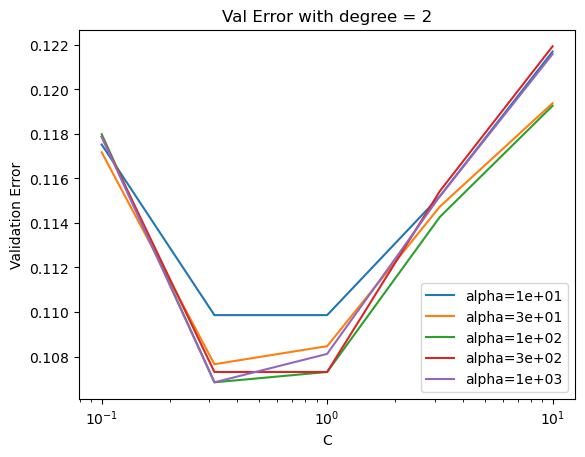

The best combination was: 
degree: 2 
alpha: 1000.0 
C: 0.31622776601683794 
Val Err: 0.1068445475638051


In [117]:
display_res('BoW_poly_CV/BoW_poly_CV_alpha_1.0_3.0_n_alpha_5_deg_2_2_C_-1.0_1.0_n_C_5_folds_5.pkl')

Let's refine our search to alphas in logspace(2,4,5) and C in logspace(-1, 0, 5)

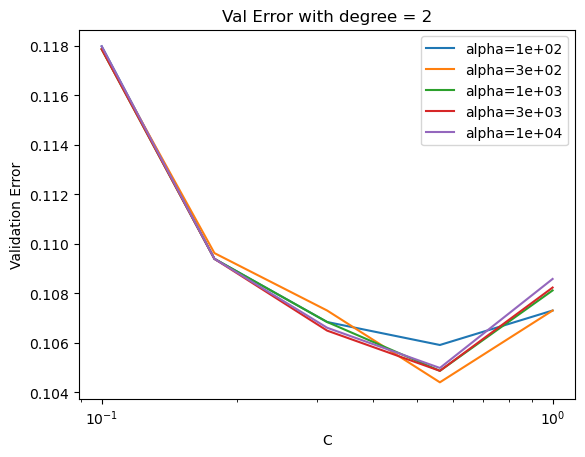

The best combination was: 
degree: 2 
alpha: 316.22776601683796 
C: 0.5623413251903491 
Val Err: 0.10440835266821347


In [118]:
display_res('BoW_poly_CV/BoW_poly_CV_alpha_2.0_4.0_n_alpha_5_deg_2_2_C_-1.0_0.0_n_C_5_folds_5.pkl')

Now that we have some sense of the range for alpha and C, lets explore some higher degrees. In this next section, we search over alphas = logspace(1,3, 5) and cs = np.logspace(-1, 0, 5), while looking at deg 3 and 4.

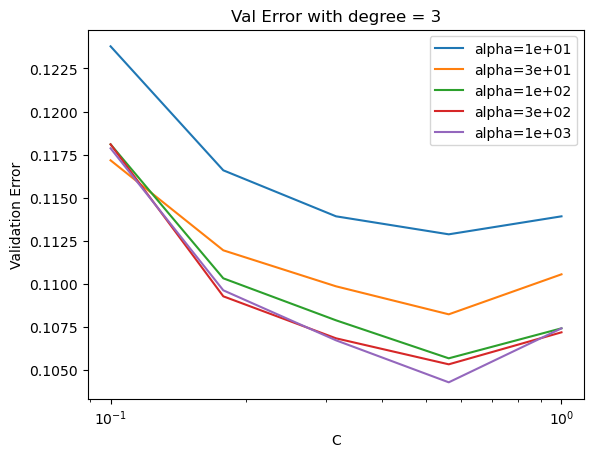

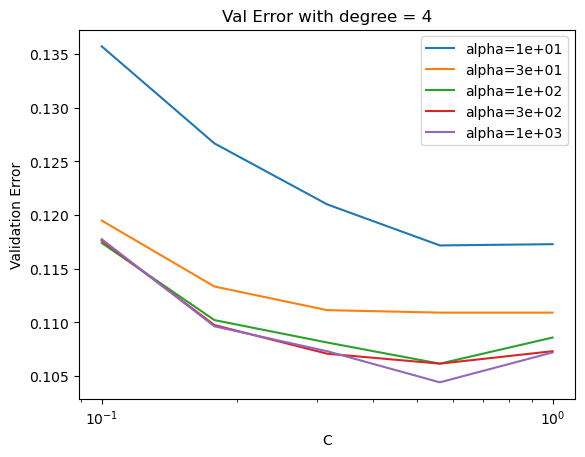

The best combination was: 
degree: 3 
alpha: 1000.0 
C: 0.5623413251903491 
Val Err: 0.10429234338747101


In [121]:
display_res('BoW_poly_CV/BoW_poly_CV_alpha_1.0_3.0_n_alpha_5_deg_3_4_C_-1.0_0.0_n_C_5_folds_5.pkl')

It's clear that increasing alpha even more gives us better predictors for these. We investigate alpha in logspace(2,4,10), deg in range(3,5), c in logspace(-0.5, 0, 10) with 5 folds.

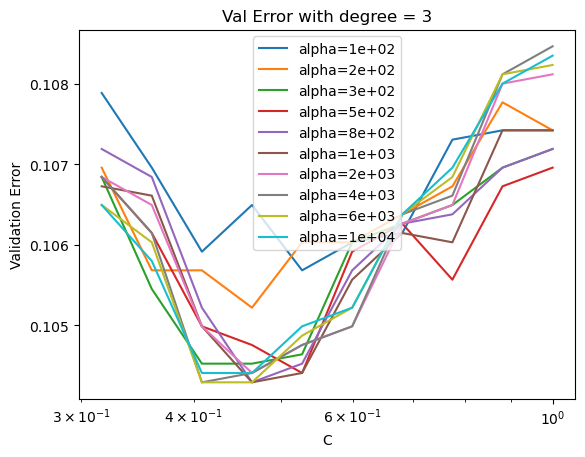

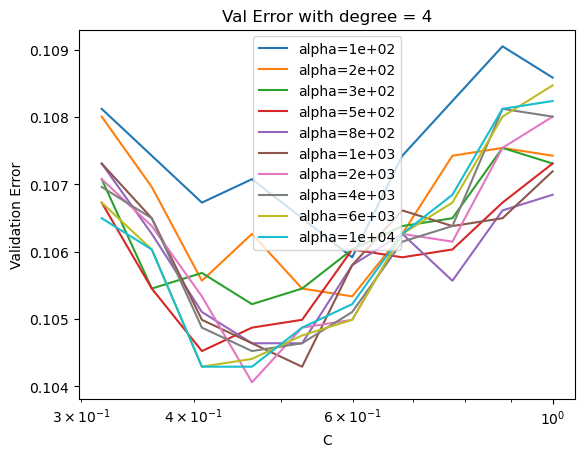

The best combination was: 
degree: 4 
alpha: 2154.4346900318824 
C: 0.46415888336127786 
Val Err: 0.1040603248259861


In [122]:
display_res('BoW_poly_CV/BoW_poly_CV_alpha_2.0_4.0_n_alpha_10_deg_3_4_C_-0.5_0.0_n_C_10_folds_5.pkl')

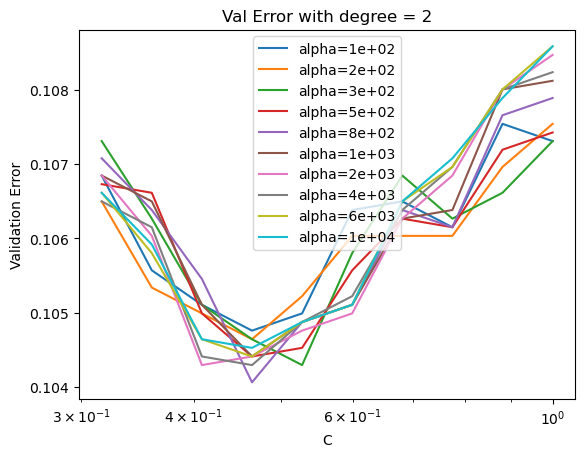

The best combination was: 
degree: 2 
alpha: 774.263682681127 
C: 0.46415888336127786 
Val Err: 0.1040603248259861


In [123]:
display_res('BoW_poly_CV/BoW_poly_CV_alpha_2.0_4.0_n_alpha_10_deg_2_2_C_-0.5_0.0_n_C_10_folds_5.pkl')

Now let's compare the errors amongst these parameters to find the best parameters for our polynomial kernel.

In [126]:
errs = []
degs = []
alphas = []
cs = []
for path in os.listdir('BoW_poly_CV'):
    with open(f"BoW_poly_CV/{path}", 'rb') as f:
        deg, alpha, c, err = pickle.load(f)
    errs.append(err)
    cs.append(c)
    degs.append(deg)
    alphas.append(alpha)
best_err = np.inf
best_alpha = 0
best_c = 0
best_deg = 0
for i, err in enumerate(errs):
    if np.min(err) < best_err:
        best_err = np.min(err)
        deg_id, alpha_id, c_id = np.unravel_index(np.argmin(err), err.shape)
        best_alpha = alphas[i][alpha_id]
        best_c = cs[i][c_id]
        best_deg = degs[i][deg_id]
best_poly = (best_deg, best_alpha, best_c, best_err)
print(f"The best err achieved was {best_err} with beta = {best_beta:.2e} and c = {best_c:.2e}")

The best err achieved was 0.1040603248259861 with beta = 4.64e-03 and c = 4.64e-01


Lets train the two models and see what they look like

(1) 0-1, Hinge training loss? (2) Margin loss? (3) Test error? (4) Support Vectors?

In [138]:
beta, c_rbf, err = best_rbf
svm_rbf = svm.SVC(C=c_rbf, kernel='precomputed')
with open(f'BoW_G_RBF_gram/BoW_G_RBF_gram_beta_{beta:.1e}.pkl', 'rb') as f:
    ker_rbf = pickle.load(f)
svm_rbf.fit(ker_rbf, y_train)

SVC(C=np.float64(5994.8425031894085), kernel='precomputed')

In [139]:
deg, alpha, c_poly, err = best_poly
svm_poly = svm.SVC(C = c_poly, kernel='precomputed')
with open(f'BoW_poly_gram/bow_gram_poly_deg_{deg}_alpha_{alpha:.0e}.pkl', 'rb') as f:
    ker_poly = pickle.load(f)
svm_poly.fit(ker_poly, y_train)

SVC(C=np.float64(0.46415888336127786), kernel='precomputed')

Lets look at the different types of training losses for these two.

In [ ]:
# 0-1 loss
print(f"The 0-1 loss for the rbf svm model is {np.mean(svm_rbf.predict(ker_rbf) != y_train)}")
print(f"The 0-1 loss for the poly svm model is {np.mean(svm_poly.predict(ker_poly) != y_train)}")
# Hinge Loss
print(f"The hinge loss for the rbf svm model is {np.mean(np.maximum(0, 1 - y_train * svm_rbf.predict(ker_rbf)))}")
print(f"The hinge loss for the poly svm model is {np.mean(np.maximum(0, 1 - y_train * svm_poly.predict(ker_poly)))}")

The 0-1 loss for the rbf svm model is 0.0033642691415313227
The 0-1 loss for the poly svm model is 0.027726218097447797
The hinge loss for the rbf svm model is 0.006728538283062645
The hinge loss for the poly svm model is 0.055452436194895594


Lets look at the margin violations

In [141]:
print(f"The number of margin violations for the rbf svm model is {np.sum(svm_rbf.decision_function(ker_rbf) * y_train < 1)}")
print(f"The number of margin violations for the poly svm model is {np.sum(svm_poly.decision_function(ker_poly) * y_train < 1)}")

The number of margin violations for the rbf svm model is 1337
The number of margin violations for the poly svm model is 2145


Let's look at the predictions of these models

In [ ]:
X_test = utils.load_data(os.path.join(os.getcwd(), "data/cleaned_tweets_test.tsv"),type="test")
test_rbf = rbf_kernel_gram(BoW_inner, beta=beta)(X_test, X_train)
test_poly = poly_kernel_gram(BoW_inner, deg=deg, alpha=alpha)(X_test, X_train)
test_poly = (test_poly - np.mean(test_poly))/np.std(test_poly)

In [148]:
preds_rbf = svm_rbf.predict(test_rbf)
preds_poly = svm_poly.predict(test_poly)
print(f'The percent of test samples that the two models predict differently are: {np.mean(preds_poly != preds_rbf) * 100}%')

The percent of test samples that the two models predict differently are: 8.516483516483516%


Lets look at some specific examples where they differ.

In [161]:
list = np.arange(len(preds_rbf))[preds_poly != preds_rbf]
for i in range(5):
    idx = list[i]
    print(X_train[idx])
    print(f"The poly svm predicted this as {preds_poly[idx]}")
    print(f"The rbf svm predicted this as {preds_rbf[idx]}")

@United is freaking worthless. I hate this airline. http://t.co/dN1if2cGwE
The poly svm predicted this as -1
The rbf svm predicted this as 1
@AmericanAir I understand the weather issue but you can't expect passengers to wait 24 hours inside airports for whatever reason. Outrageous
The poly svm predicted this as -1
The rbf svm predicted this as 1
@JetBlue We just landed in Vegas but not allowed to leave the plane just yet. Thanks for making me miss my flight at 1 pm. #fustrated
The poly svm predicted this as 1
The rbf svm predicted this as -1
@USAirways Kudos to Robin at @PHXSkyHarbor Lost/Found for reuniting me w/ my iPad. She was delightful to work with!
The poly svm predicted this as -1
The rbf svm predicted this as 1
@SouthwestAir y'all are fast we already have our 5 winners! Congrats!!
The poly svm predicted this as 1
The rbf svm predicted this as -1


Honestly I can't really interpret why these predicted the way they did. For some of these it seems like seeing 'thanks' or 'lost' was enough to sway the prediction.

It seems that the gaussian rbf slightly outperformed the poly svm model in training, but I'm not sure how this generalizes. I'm inclined to say it will generalize worse than the poly svm, since they managed very similar validation error, while the rbf managed a very low training error.

In [157]:
def my_final_predictor(x_data_to_predict_on, model = "poly"): # you might change the input if you use precomputed kernels
    #### TASK 5 CODE
    if model == "rbf":
        svm_clf = svm.SVC(C= c_rbf, kernel='precomputed')
        svm_clf.fit(ker_rbf, y_train)
        input_preds = rbf_kernel_gram(BoW_inner, beta=beta)(x_data_to_predict_on, X_train)
        my_predictions = svm_clf.predict(input_preds)      # an array of +1/-1 the same length as x_data_to_predict
    if model == "poly":
        svm_clf = svm.SVC(C = c_poly, kernel='precomputed')
        svm_clf.fit(ker_poly, y_train)
        input_preds = poly_kernel_gram(BoW_inner, deg=deg, alpha=alpha)(x_data_to_predict_on, X_train)
        my_predictions = svm_clf.predict(input_preds)
    #### TASK 5 CODE
    return my_predictions

You are now ready to ship your predictor!!  Hurray!!  
Let's use it, and see how well it does.

In [55]:
X_test = utils.load_data(os.path.join(os.getcwd(), "data/cleaned_tweets_test.tsv"),type="test")

In [ ]:
with open(f'worker2output/bow_gram_poly_deg_{best_deg}_alpha_{best_alpha:.0e}.pkl', 'rb') as f:
    ker = pickle.load(f)
test_predictions = my_final_predictor(X_test, ker)

In [ ]:
print(f"My predictions: {test_predictions}") ### this should be a list of +1/-1 ###
print(f"It is of length {len(test_predictions)}.") ### this should of size X_test = 2192 ###
print(f"My predictions: {preds_rbf}") ### this should be a list of +1/-1 ###
print(f"It is of length {len(preds_rbf)}.") ### this should of size X_test = 2192 ###
print(f"My predictions: {preds_poly}") ### this should be a list of +1/-1 ###
print(f"It is of length {len(preds_poly)}.") ### this should of size X_test = 2192 ###
print(f"{np.sum(test_predictions!=preds_poly)}")

My predictions: [-1 -1 -1 ... -1 -1 -1]
It is of length 2912.
My predictions: [-1 -1 -1 ... -1 -1 -1]
It is of length 2912.
My predictions: [-1 -1 -1 ... -1 -1 -1]
It is of length 2912.
0


Yay, It did not crash!! Now let us convert the list into a csv file. You can export the tsv file and submit it on [Kaggle](https://www.kaggle.com/t/ed3bead259169073ec68e3e9fbf6b247), to see yourself on the leaderboard!!!


In [156]:
with open("y_predicted_rbf.csv", "w") as f:
    f.write("ID,label\n")  # Write header
    for i, label in enumerate(preds_rbf, start=1):
        f.write(f"{i},{label}\n")  # Write ID and label